In [0]:
import numpy as np
from keras import models
from keras.models import Model, load_model
from keras import layers
from keras.layers import Dropout, Input
from keras import backend as K
from sklearn.model_selection import train_test_split
import shutil
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os 
import pandas as pd
from sklearn.model_selection import train_test_split

# Load encoder model

In [3]:
embedding_model = load_model('/content/drive/My Drive/Colab/Roonyx/Face recognition/07.06.2020/MODEL_embedding.h5')
embedding_model.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 222, 222, 128)     3584      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 109, 109, 128)     147584    
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 52, 52, 128)       147584    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 26, 26, 128)       0 

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Model for age prediction

In [0]:
def model_function(input_shape):

  base_input = Input(input_shape) 
  embedding_layers = embedding_model.layers[:-1]
  x1 = embedding_layers[0](base_input)
  for i in range(1,len(embedding_layers),1):
    x1 = embedding_layers[i](x1)

  x1 = layers.Dense(64, activation='relu')(x1)
  x1 = layers.Dense(1, activation='linear')(x1)

  model = Model(base_input, x1, name='age')

  for i in range(0,12,1):
    model.layers[i].trainable = False

  return model

In [5]:
model = model_function((224, 224, 3))
model.summary()

Model: "age"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 222, 222, 128)     3584      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 109, 109, 128)     147584    
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 52, 52, 128)       147584  

# Reading metadata

In [0]:
file_names = os.listdir("/content/drive/My Drive/Colab/Roonyx/Face recognition/UTKFace/224_224")

In [0]:
ages = []
path = []
for i in range(0,len(file_names),1):
  index_dot = str(file_names[i]).find('_')
  ages.append(int(file_names[i][:index_dot]))
  path.append("/content/drive/My Drive/Colab/Roonyx/Face recognition/UTKFace/224_224/" + str(file_names[i]))

In [0]:
path_train, path_test, ages_train, ages_test = train_test_split(path, ages, random_state=0)

data_train = np.transpose([path_train, ages_train])
data_test = np.transpose([path_test, ages_test])
  
df_train = pd.DataFrame(data_train, columns = ['Path', 'Age']) 
df_test = pd.DataFrame(data_test, columns = ['Path', 'Age']) 

# Generators

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        df_train,
        x_col = "Path",
        y_col = "Age",
        class_mode = "raw",
        target_size=(224, 224),
        batch_size=30)

test_generator = test_datagen.flow_from_dataframe(
        df_test,
        x_col = "Path",
        y_col = "Age",
        class_mode = "raw",
        target_size=(224, 224),
        batch_size=30)

Found 19237 validated image filenames.
Found 6413 validated image filenames.


# Model training

In [0]:
model = model_function(input_shape = (224, 224, 3))
model.compile(loss='mse', optimizer="adam", metrics = ["mae"])

history = model.fit(
              train_generator,
              steps_per_epoch=10,
              epochs=20,
              validation_data=test_generator,
              validation_steps=5)

Epoch 1/20
10/10 [==============================] - 80s 8s/step - loss: 623.5031 - mae: 20.1698 - val_loss: 351.5773 - val_mae: 21.6925
Epoch 2/20
10/10 [==============================] - 71s 7s/step - loss: 459.7381 - mae: 16.9318 - val_loss: 420.2278 - val_mae: 16.5338
Epoch 3/20
10/10 [==============================] - 76s 8s/step - loss: 485.5815 - mae: 16.5581 - val_loss: 204.5734 - val_mae: 13.8959
Epoch 4/20
10/10 [==============================] - 85s 9s/step - loss: 417.6768 - mae: 16.3931 - val_loss: 194.0362 - val_mae: 15.9921
Epoch 5/20
10/10 [==============================] - 72s 7s/step - loss: 410.9610 - mae: 15.0397 - val_loss: 519.3746 - val_mae: 14.1776
Epoch 6/20
10/10 [==============================] - 79s 8s/step - loss: 382.8488 - mae: 14.8717 - val_loss: 206.1725 - val_mae: 13.0564
Epoch 7/20
10/10 [==============================] - 58s 6s/step - loss: 338.4471 - mae: 14.4410 - val_loss: 273.1219 - val_mae: 12.3936
Epoch 8/20
10/10 [==============================

# Model loss and accuracy

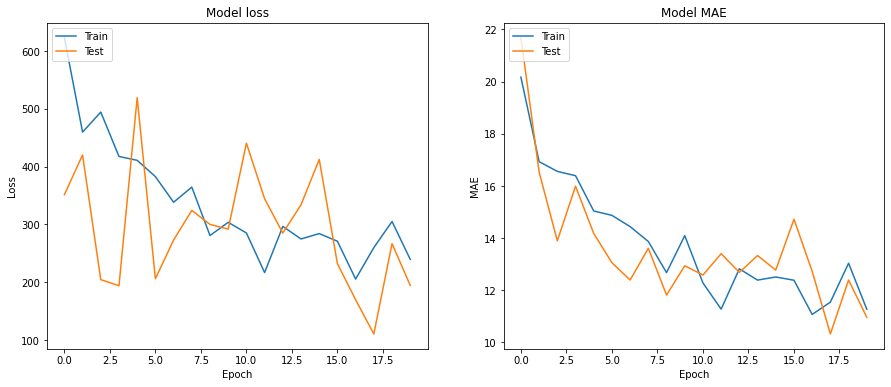

In [0]:
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Model training 2

In [0]:
history2 = model.fit(
              train_generator,
              steps_per_epoch=10,
              epochs=20,
              validation_data=test_generator,
              validation_steps=5)

Epoch 1/20
10/10 [==============================] - 57s 6s/step - loss: 203.8199 - mae: 11.2439 - val_loss: 262.0101 - val_mae: 12.4864
Epoch 2/20
10/10 [==============================] - 54s 5s/step - loss: 275.1767 - mae: 12.5225 - val_loss: 253.4492 - val_mae: 12.8233
Epoch 3/20
10/10 [==============================] - 57s 6s/step - loss: 250.4242 - mae: 12.1308 - val_loss: 79.8056 - val_mae: 10.0791
Epoch 4/20
10/10 [==============================] - 38s 4s/step - loss: 242.8626 - mae: 11.5601 - val_loss: 101.3565 - val_mae: 11.9264
Epoch 5/20
10/10 [==============================] - 48s 5s/step - loss: 239.7570 - mae: 11.5246 - val_loss: 329.6366 - val_mae: 10.8603
Epoch 6/20
10/10 [==============================] - 39s 4s/step - loss: 205.1988 - mae: 10.3674 - val_loss: 147.7619 - val_mae: 9.7012
Epoch 7/20
10/10 [==============================] - 59s 6s/step - loss: 248.9290 - mae: 11.8555 - val_loss: 167.9940 - val_mae: 10.0878
Epoch 8/20
10/10 [==============================] 

# Model loss and accuracy 2

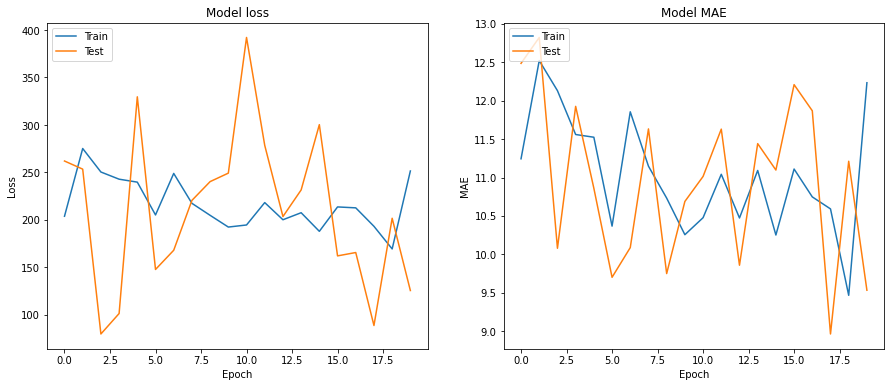

In [0]:
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history2.history['mae'])
plt.plot(history2.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Model training 3

In [0]:
history3 = model.fit(
              train_generator,
              steps_per_epoch=10,
              epochs=20,
              validation_data=test_generator,
              validation_steps=5)

Epoch 1/20
10/10 [==============================] - 32s 3s/step - loss: 192.4389 - mae: 10.3496 - val_loss: 186.1709 - val_mae: 11.5584
Epoch 2/20
10/10 [==============================] - 25s 2s/step - loss: 219.9057 - mae: 10.9994 - val_loss: 215.9102 - val_mae: 11.0759
Epoch 3/20
10/10 [==============================] - 44s 4s/step - loss: 247.3167 - mae: 11.8475 - val_loss: 56.8519 - val_mae: 8.7482
Epoch 4/20
10/10 [==============================] - 38s 4s/step - loss: 175.5939 - mae: 9.7413 - val_loss: 100.6503 - val_mae: 10.6737
Epoch 5/20
10/10 [==============================] - 34s 3s/step - loss: 161.2382 - mae: 9.5512 - val_loss: 281.4424 - val_mae: 10.4130
Epoch 6/20
10/10 [==============================] - 45s 5s/step - loss: 176.5171 - mae: 9.9069 - val_loss: 125.8127 - val_mae: 9.1559
Epoch 7/20
10/10 [==============================] - 38s 4s/step - loss: 180.9971 - mae: 9.7815 - val_loss: 143.3012 - val_mae: 9.3228
Epoch 8/20
10/10 [==============================] - 31s 

# Model loss and accuracy 3

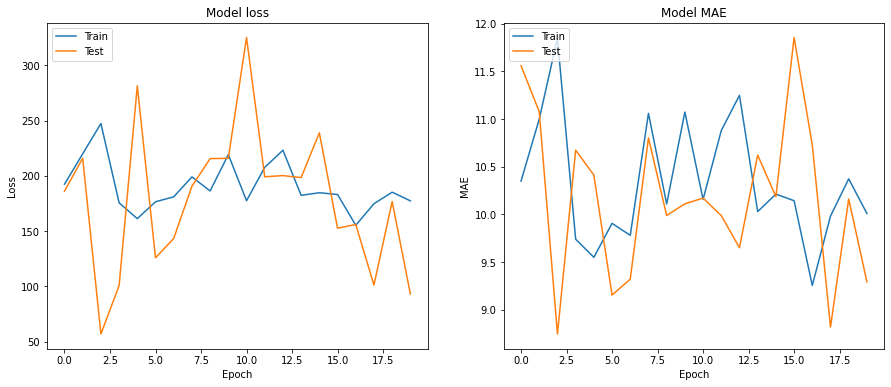

In [0]:
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history3.history['mae'])
plt.plot(history3.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [0]:
model.save("/content/drive/My Drive/Colab/Roonyx/Face recognition/07.06.2020/MODEL_age_without_resnet.h5")

# Example of prediction

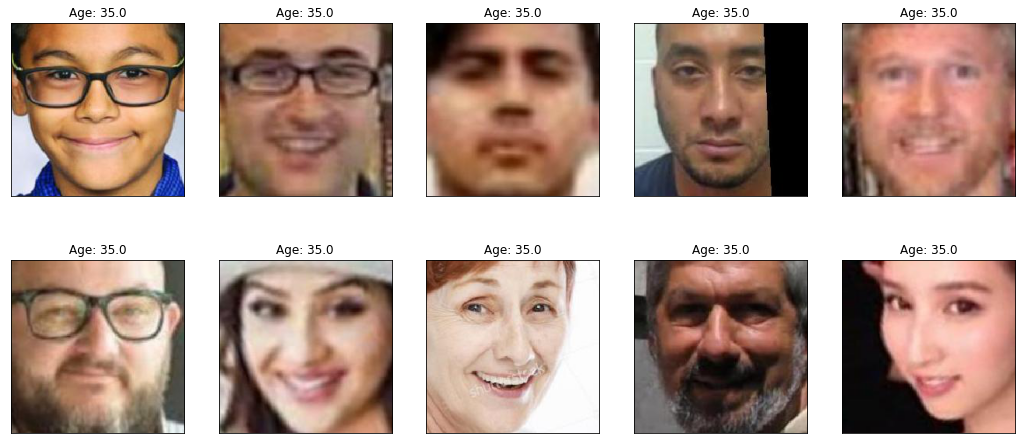

In [0]:
images = test_generator.next()[0]
images = images[:10]

labels = []
for i in range(0,len(images),1):
  prediction = model.predict(images[i:i+1]/255)[0][0]
  labels.append("Age: {}".format(round(prediction)))

fix,axes = plt.subplots(2,5, figsize=(18,8), subplot_kw={'xticks':(),'yticks':()})
for img, label, ax in zip(images, labels, axes.ravel()):
    ax.imshow(img, cmap=plt.cm.binary)
    ax.set_title(label)